In [1]:
import nltk
import tiktoken
import pandas as pd
from transformers import LlamaTokenizerFast
from scipy import stats
from collections import defaultdict
from readability import Readability
import os
from statsmodels.stats import inter_rater as ir
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
import matplotlib.pyplot as plt
import numpy as np
import json
from collections import defaultdict
from summ_eval.data_stats_metric import DataStatsMetric
from matplotlib.patches import Patch
import csv
import itertools

In [2]:
annotators = ['Annotator1', 'Annotator2', 'Annotator3']
anno_files = ['gpt4-errors.json', 'claude-errors.json', 'llama-errors.json']
mapping = {'gpt4-errors.json': 'GPT-4', 'claude-errors.json': 'Claude', 'llama-errors.json': 'Llama'}
error_labels = ['feeling', 'causation', 'action', 'character', 'setting', 'no-consensus']
score_models = ['gpt-4-1106-preview', 'claude-2.1']
claude_skip_list = ['112332_2claude', '603720_1claude']
models = ['gpt4', 'claude', 'llama']
modelnames = ['GPT-4', 'Claude', 'Llama']
attributes = ['Coverage', 'Faithfulness', 'Coherence', 'Interpretation']
interface_model_map = {'Summary 1': 'claude', 'Summary 2': 'gpt4', 'Summary 3': 'llama'}

# Load the data

In [3]:
# Load writer evaluation

ratings = defaultdict(dict)
with open('writer_ratings_comments.tsv') as f:
    tsv = csv.DictReader(f, delimiter="\t")
    for row in tsv:
        uid = row['SummID']
        user = row['UserID'] if '_' in row['UserID'] else row['UserID'] + '_0'
        if not uid and f'{user}claude' not in claude_skip_list:
            ratings['ranking'][user] = row
        elif uid and uid not in claude_skip_list:
            model = uid[len(user):]
            ratings[model][user] = row
for model in models:
    print(f"Loaded {len(ratings[model].keys())} ratings for {model}")
print(f"Loaded {len(ratings['ranking'].keys())} rankings")

Loaded 25 ratings for gpt4
Loaded 23 ratings for claude
Loaded 25 ratings for llama
Loaded 23 rankings


In [4]:
# Parse the annotated errors

def parse_errors(errors):
    errlist = []
    for i in range(1, 21):
        errlist.append(errors[f'Error {i}'])
    return errlist

def get_majority_labels(anno1, anno2, anno3):
    maj_labels = []
    for idx, (ann1, ann2, ann3) in enumerate(zip(anno1, anno2, anno3)):
        if (ann1[1] == ann2[1]) or (ann1[1] == ann3[1]):
            lab = ann1[1] if ann1[1] != '_' else 'no-consensus'
        elif ann2[1] == ann3[1]:
            lab = ann2[1] if ann2[1] != '_' else 'no-consensus'
        else:
            lab = 'no-consensus'
        maj_labels.append(lab)
    return maj_labels

annotated_errors = {}
for annotator in annotators:
    annotated_errors[annotator] = {}
    for file in anno_files:
        with open(f'error_annotations/{annotator}/{file}', 'r') as f:
            annotated_errors[annotator][file] = parse_errors(json.loads(f.read()))
    print(f"Loaded {sum([len(annotated_errors[annotator][file]) for file in anno_files])} annotations for {annotator}")

annotated_errors['majority'] = {}
for file in anno_files:
    annotated_errors['majority'][file] = get_majority_labels(
        annotated_errors[annotators[0]][file],
        annotated_errors[annotators[1]][file],
        annotated_errors[annotators[2]][file]
    )
            
for model in score_models:
    annotated_errors[model] = {}
    for file in anno_files:
        with open(f'error_annotations/{model}/{model}_{file}', 'r') as f:
            annotated_errors[model][file] = parse_errors(json.loads(f.read()))
    print(f"Loaded {sum([len(annotated_errors[model][file]) for file in anno_files])} annotations for {model}")

Loaded 60 annotations for Annotator1
Loaded 60 annotations for Annotator2
Loaded 60 annotations for Annotator3
Loaded 60 annotations for gpt-4-1106-preview
Loaded 60 annotations for claude-2.1


# -----------------------------

# Inter-Annotator Fleiss-Kappa

In [5]:
anno1 = itertools.chain.from_iterable([annotated_errors[annotators[0]][file] for file in anno_files])
anno2 = itertools.chain.from_iterable([annotated_errors[annotators[1]][file] for file in anno_files])
anno3 = itertools.chain.from_iterable([annotated_errors[annotators[2]][file] for file in anno_files])

raters = []
for ann1, ann2, ann3 in zip(anno1, anno2, anno3):
    raters.append([ann1[1], ann2[1], ann3[1]])
arr, labs = ir.aggregate_raters(raters)
print('Fleiss Kappa', round(ir.fleiss_kappa(arr), 2))

Fleiss Kappa 0.51


# Table 3

In [6]:
for model in models:
    attr_avgs = []
    all_scores= []
    for attr in attributes:
        attr_scores = [float(rating[attr]) for rating in ratings[model].values() if rating[attr] != '-1']
        attr_avgs.append(round(np.mean(attr_scores), 2))
        all_scores.extend(attr_scores)
    print(model, attr_avgs, round(np.mean(all_scores), 2))
print('------------------------')
for model in models:
    attr_percents = []
    all_scores = [0, 0]
    for attr in attributes:
        attr_scores = [float(rating[attr]) for rating in ratings[model].values() if rating[attr] != '-1']
        attr_percents.append(round(attr_scores.count(4)*100/len(attr_scores)))
        all_scores[0] += attr_scores.count(4)
        all_scores[1] += len(attr_scores)
    print(model, attr_percents, round(all_scores[0]*100/all_scores[1]))

gpt4 [3.48, 3.12, 3.52, 3.4] 3.38
claude [3.17, 2.65, 3.41, 3.26] 3.12
llama [2.4, 1.92, 3.08, 2.76] 2.54
------------------------
gpt4 [56, 44, 60, 56] 54
claude [39, 30, 59, 43] 43
llama [12, 8, 32, 20] 18


# Figure 5

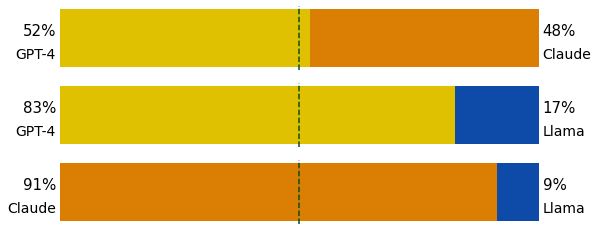

In [7]:
def make_hbar(ax, values1, values2, color1, color2, model1, model2):
    bar1 = ax.barh([''], values1, label='', color=color1)
    bar2 = ax.barh([''], values2, label='', color=color2, left=values1)
    ax.axvline(11.5, color='#044F19', linestyle='--', label='')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(-.2, bar1[0].get_y() + bar1[0].get_height() / 2 + .1, f'{round(values1[0]*100/(values1[0]+values2[0]))}%',
                    ha='right', va='center', color='black', fontsize=15)
    ax.text(-.2, bar1[0].get_y() + .18, model1,
                    ha='right', va='center', color='black', fontsize=14)
    ax.text(bar1[0].get_width()+bar2[0].get_width()+.2, bar2[0].get_y() + bar2[0].get_height() / 2 + .1, f'{round(values2[0]*100/(values1[0]+values2[0]))}%',
                    ha='left', va='center', color='black', fontsize=15)
    ax.text(bar1[0].get_width()+bar2[0].get_width()+.2, bar1[0].get_y() + .18, model2,
                    ha='left', va='center', color='black', fontsize=14)

ranks = defaultdict(list)
for uid, anno in ratings['ranking'].items():
    ranking = json.loads(anno['Preference'].replace('\'', '\"'))
    for i in range(3):
        model = interface_model_map[ranking[str(i+1)]]
        ranks[model].append(i+1)
ranks['gpt4'] = np.array(ranks['gpt4'])
ranks['claude'] = np.array(ranks['claude'])
ranks['llama'] = np.array(ranks['llama'])
                
fig, axs = plt.subplots(3, 1, figsize=(9, 4))    
make_hbar(axs[0], [np.sum(ranks['gpt4']<ranks['claude'])], [np.sum(ranks['gpt4']>ranks['claude'])], '#DFC102', '#DA7F04', 'GPT-4', 'Claude')
make_hbar(axs[1], [np.sum(ranks['gpt4']<ranks['llama'])], [np.sum(ranks['gpt4']>ranks['llama'])], '#DFC102', '#0E4BA9', 'GPT-4', 'Llama')
make_hbar(axs[2], [np.sum(ranks['claude']<ranks['llama'])], [np.sum(ranks['claude']>ranks['llama'])], '#DA7F04', '#0E4BA9', 'Claude', 'Llama')
for i in range(3):
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['left'].set_visible(False)

# Table 4

In [8]:
lab_counts = {}
for file in anno_files:
    counts = {}
    total = 0
    for lab in error_labels:
        counts[lab] = annotated_errors['majority'][file].count(lab)
    for lab in error_labels:
        counts[lab] = f"{round(counts[lab]*100/20)}%"
    lab_counts[file] = counts
    
for lab in error_labels:
    overall_count = 0
    for file in anno_files:
        overall_count += annotated_errors['majority'][file].count(lab)
    print(lab, [lab_counts[anno_files[i]][lab] for i in range(3)], f'{round(overall_count*100/60)}%')

feeling ['45%', '20%', '15%'] 27%
causation ['20%', '20%', '10%'] 17%
action ['5%', '20%', '25%'] 17%
character ['5%', '5%', '30%'] 13%
setting ['15%', '15%', '15%'] 15%
no-consensus ['10%', '20%', '5%'] 12%


# Table 5

In [10]:
type_list = [('reliable', 'unreliable'), ('normal', 'rich'), ('linear', 'flashbacks')]
with open('story_labels.json', 'r') as f:
    story_types = json.loads(f.read())
    
scores_dict = {}
for model in models:
    scores_dict[model] = defaultdict(list)
    for uid, rating in ratings[model].items():
        score = np.mean([float(rating[attr]) for attr in attributes if rating[attr] != '-1'])
        for easytype, hardtype in type_list:
            if hardtype in story_types[uid]:
                scores_dict[model][hardtype].append(score)
            else:
                scores_dict[model][easytype].append(score)
    
for easytype, hardtype in type_list:
    print(easytype, len(scores_dict[models[0]][easytype]), [round(np.mean(scores_dict[model][easytype]), 2) for model in models])
    print(hardtype, len(scores_dict[models[0]][hardtype]), [round(np.mean(scores_dict[model][hardtype]), 2) for model in models])
    print('---------')

reliable 15 [3.45, 3.29, 2.6]
unreliable 10 [3.28, 2.89, 2.45]
---------
normal 16 [3.42, 2.98, 2.59]
rich 9 [3.31, 3.36, 2.44]
---------
linear 18 [3.29, 3.05, 2.56]
flashbacks 7 [3.61, 3.32, 2.5]
---------


# Table 6

In [11]:
writers, gpt4, claude = defaultdict(list), defaultdict(list), defaultdict(list)
for model in models:
    for uid, rating in ratings[model].items():
        with open(f'summary_scores/{model}_summaries/gpt-4-1106-preview_scores.json', 'r') as f:
            gpt4scores = json.loads(f.read())
        with open(f'summary_scores/{model}_summaries/claude-2.1_scores.json', 'r') as f:
            claudescores = json.loads(f.read())
        for i, attr in enumerate(attributes):
            if rating[attr] != '-1':
                writers[attr].append(float(rating[attr]))
                gpt4[attr].append(gpt4scores[uid][i])
                claude[attr].append(claudescores[uid][i])

for attr in attributes:
    gc = stats.pearsonr(writers[attr], gpt4[attr], alternative='greater')
    cc = stats.pearsonr(writers[attr], claude[attr], alternative='greater')
    print(attr, (round(gc[0], 2), round(gc[1], 3)), (round(cc[0], 2), round(cc[1], 3)))

out = "Error Labels"
for model in score_models:
    annolabs = itertools.chain.from_iterable([annotated_errors['majority'][file] for file in anno_files])
    modlabs = itertools.chain.from_iterable([annotated_errors[model][file] for file in anno_files])
    out += f' {round(cohen_kappa_score(list(annolabs), [lab[1] for lab in modlabs]), 2)}'
print(out+'\n')

Coverage (0.46, 0.0) (0.18, 0.064)
Faithfulness (0.37, 0.001) (0.05, 0.327)
Coherence (0.18, 0.062) (0.02, 0.446)
Interpretation (0.21, 0.035) (0.02, 0.421)
Error Labels 0.65 0.53



# Figure 10

Text(0, 0.5, '')

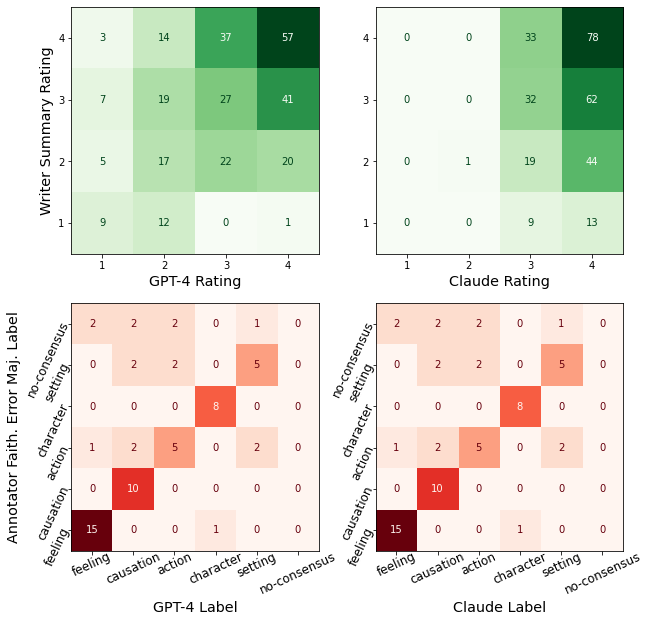

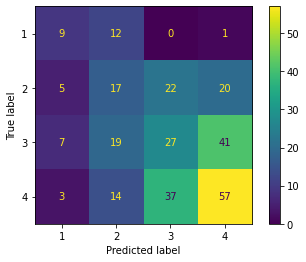

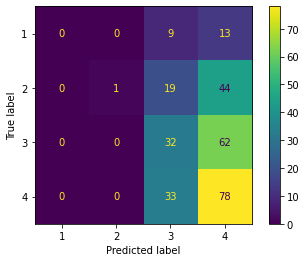

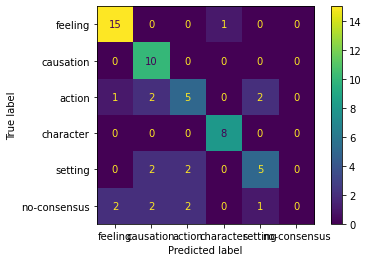

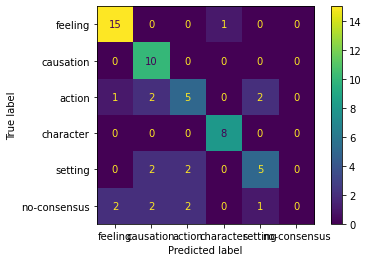

In [12]:
writers, gpt4, claude = [], [], []
for model in models:
    for uid, rating in ratings[model].items():
        with open(f'summary_scores/{model}_summaries/gpt-4-1106-preview_scores.json', 'r') as f:
            gpt4scores = json.loads(f.read())
        with open(f'summary_scores/{model}_summaries/claude-2.1_scores.json', 'r') as f:
            claudescores = json.loads(f.read())
        for i, attr in enumerate(attributes):
            if rating[attr] != '-1':
                writers.append(int(rating[attr]))
                gpt4.append(gpt4scores[uid][i])
                claude.append(claudescores[uid][i])

figs, axs = plt.subplots(2, 2, figsize=(10, 10))
model_dict = {'GPT-4': gpt4, 'Claude': claude}
for i, model in enumerate(['GPT-4', 'Claude']):
    disp = ConfusionMatrixDisplay.from_predictions(writers, model_dict[model], labels=[1, 2, 3, 4])
    disp.plot(cmap='Greens', ax=axs[0, i])
    disp.im_.colorbar.remove()
    axs[0, i].set_xlabel(f'{model} Rating', fontsize='x-large')
    axs[0, i].invert_yaxis()
axs[0, 0].set_ylabel('Writer Summary Rating', fontsize='x-large')
axs[0, 1].set_ylabel('')

majlabs, gpt4labs, claudelabs = [], [], []
for file in anno_files:
    for ml, gp, cl in zip(annotated_errors['majority'][file], annotated_errors[score_models[0]][file], annotated_errors[score_models[1]][file]):
        majlabs.append(ml)
        gpt4labs.append(gp[1])
        claudelabs.append(cl[1])

model_dict = {'GPT-4': gpt4labs, 'Claude': claudelabs}
for i, model in enumerate(['GPT-4', 'Claude']):
    disp = ConfusionMatrixDisplay.from_predictions(majlabs, gpt4labs, labels=error_labels)
    disp.plot(cmap='Reds', ax=axs[1, i])
    disp.im_.colorbar.remove()
    axs[1, i].invert_yaxis()
    axs[1, i].set_xlabel(f"{model} Label", fontsize='x-large')
    axs[1, i].set_xticklabels(error_labels, rotation=25, position=(0, 0.03), fontsize=12)
    axs[1, i].set_yticklabels(error_labels, rotation=65, position=(0.03, .1), fontsize=12)
axs[1, 0].set_ylabel("Annotator Faith. Error Maj. Label", fontsize='x-large')
axs[1, 1].set_ylabel("")

# BooookScore Correlation

In [13]:
with open('summary_scores/boookscore_scores.json', 'r') as f:
    bs_scores = json.loads(f.read())
    
writers, bookscore = [], []
for model in models:
    for uid, rating in ratings[model].items():
        writers.append(float(rating['Coherence']))
        bookscore.append(float(bs_scores[f'{uid}{model}']))

cc, pv = stats.pearsonr(writers, bookscore, alternative='greater')
print("Correlation to Coherence", round(cc, 2), round(pv, 3))

writers = []
for model in models:
    for uid, rating in ratings[model].items():
        writers.append(np.mean([float(rating[attr]) for attr in attributes if rating[attr] != '-1']))

cc, pv = stats.pearsonr(writers, bookscore, alternative='greater')
print("Correlation to Overall Score", round(cc, 2), round(pv, 3))

for model in models:
    scores = []
    for uid, rating in ratings[model].items():
        scores.append(float(bs_scores[f'{uid}{model}']))
    print(model, "average score", round(np.mean(scores), 2))

Correlation to Coherence 0.11 0.178
Correlation to Overall Score 0.27 0.01
gpt4 average score 0.95
claude average score 0.93
llama average score 0.93
